Robots are smart… by design. To fully understand and properly navigate a task, however, they need input about their environment.

Help robots recognize the floor surface they’re standing on using data collected from Inertial Measurement Units (IMU sensors).

In [1]:
## importing libraries required
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#print(os.listdir("../input"))
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing 

In [28]:
from sklearn import preprocessing 

from xgboost import XGBClassifier

In [2]:
# Change directory
#path = "../input"
path = os.getcwd() 
os.chdir(path)
print( path )

C:\kaggle_arpana\career-con-2019


In [3]:
#read Train and Test Data
X_train_robo=pd.read_csv('X_train.csv')
X_test_robo=pd.read_csv('X_test.csv')
y_train_robo=pd.read_csv('y_train.csv')
sample = pd.read_csv('sample_submission.csv')

## *Viewing the Train and Test data

In [4]:
X_train_robo.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [5]:
y_train_robo.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


### y_train.csv - the surfaces for training set.

- series_id: ID number for the measurement series.

- group_id: ID number for all of the measurements taken in a recording session. Provided for the training set only, to enable more cross validation strategies.

- surface: the target for this competition.

In [6]:
X_test_robo.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


### X_[train/test].csv - the input data, covering 10 sensor channels and 128 measurements per time series plus three ID columns:

- row_id: The ID for this row.

- series_id: ID number for the measurement series. Foreign key to y_train/sample_submission.

- measurement_number: Measurement number within the series.
- sensor channels: 
        orientation_X
        orientation_Y
        orientation_Z
        orientation_W
        angular_velocity_X
        angular_velocity_Y
        angular_velocity_Z
        linear_acceleration_X
        linear_acceleration_Y
        linear_acceleration_Z

## Size of Dataset

In [7]:
print("X_Train : " , X_train_robo.shape)
print("X_Test : " , X_test_robo.shape)
print("y_Train : " , y_train_robo.shape)

X_Train :  (487680, 13)
X_Test :  (488448, 13)
y_Train :  (3810, 3)


### we can observe predictors and target has different number of rows.

In [8]:
print("Train series count : %d" % len(X_train_robo.series_id.value_counts()))
print("Test series count : %d" % len(X_test_robo.series_id.value_counts()))

Train series count : 3810
Test series count : 3816


In [9]:
print("Train measurement_number count : %d" % len(X_train_robo.measurement_number.value_counts()))
print("Test measurement_number count : %d" % len(X_test_robo.measurement_number.value_counts()))

Train measurement_number count : 128
Test measurement_number count : 128


### we can see Test data has 6 extra series than Train data
### Train set has measurement  series count of 3810 with each of 128 measurement number

## check for missing, NA values

In [10]:
print("X_Train : \n" , X_train_robo.isna().sum())
print("---------------------------")
print("X_Test : \n" , X_test_robo.isna().sum())
print("---------------------------")
print("y_Train : \n" , y_train_robo.isna().sum())

X_Train : 
 row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64
---------------------------
X_Test : 
 row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64
---------------------------
y_Train : 
 series_id    0
group_id     0
surface      0
dtype: int64


### no NA values in Train and Test data

In [11]:
X_train_robo.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


In [12]:
X_test_robo.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000
mean,1907.500000,63.500000,0.031996,0.120651,0.018735,0.004024,0.000401,0.013669,-0.036101,0.125433,2.906588,-9.359811
std,1101.585403,36.949327,0.671977,0.714522,0.108481,0.100957,0.114485,0.089440,0.233791,1.832639,2.094727,2.802670
min,0.000000,0.000000,-0.989720,-0.989810,-0.154680,-0.156270,-2.403300,-1.193000,-1.458200,-35.040000,-107.480000,-83.173000
25%,953.750000,31.750000,-0.648130,-0.744503,-0.112660,-0.098435,-0.037396,-0.029865,-0.089842,-0.486233,2.052100,-10.125000
50%,1907.500000,63.500000,0.132910,0.397860,0.057271,0.022654,0.001107,0.007276,-0.008911,0.112490,2.900300,-9.361700
75%,2861.250000,95.250000,0.575270,0.803600,0.124770,0.083706,0.037827,0.051112,0.057876,0.727250,3.758000,-8.582075
max,3815.000000,127.000000,0.989320,0.988940,0.154250,0.152510,3.396600,1.150700,0.960280,36.628000,55.624000,59.633000


# group the rows according to series id

In [13]:
train = pd.merge(X_train_robo,y_train_robo, on= ['series_id'])
train.shape

(487680, 15)

In [14]:
train.group_id.nunique()

73

### dropping measurement_number after merging columns

In [15]:
test = X_test_robo.copy()

In [16]:
train.drop(["measurement_number"], axis=1, inplace=True)
test.drop(["measurement_number"], axis=1, inplace=True)

In [17]:
print("train:",train.shape)
print("test:",test.shape)

train: (487680, 14)
test: (488448, 12)


### check data types of features

In [18]:
train.dtypes

row_id                    object
series_id                  int64
orientation_X            float64
orientation_Y            float64
orientation_Z            float64
orientation_W            float64
angular_velocity_X       float64
angular_velocity_Y       float64
angular_velocity_Z       float64
linear_acceleration_X    float64
linear_acceleration_Y    float64
linear_acceleration_Z    float64
group_id                   int64
surface                   object
dtype: object

In [19]:
test.dtypes

row_id                    object
series_id                  int64
orientation_X            float64
orientation_Y            float64
orientation_Z            float64
orientation_W            float64
angular_velocity_X       float64
angular_velocity_Y       float64
angular_velocity_Z       float64
linear_acceleration_X    float64
linear_acceleration_Y    float64
linear_acceleration_Z    float64
dtype: object

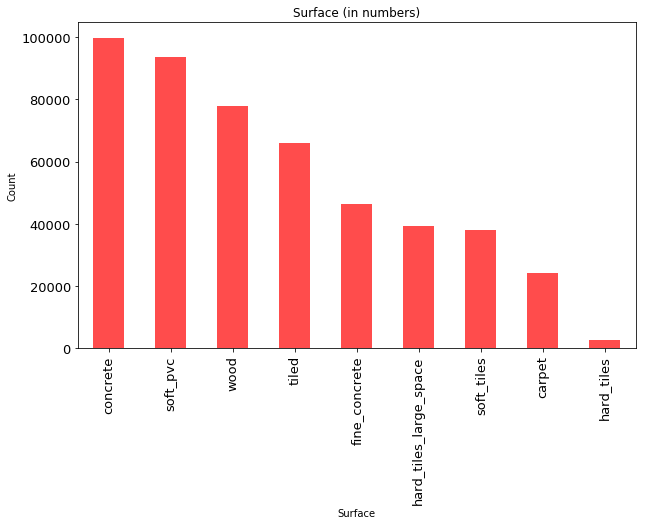

In [20]:
# plt.figure(figsize=(10,10)
train.surface.value_counts().plot(kind='bar',
                                 figsize=(10,6),
                                  color="red",
                                  alpha = 0.7,
                                  fontsize=13)
plt.title('Surface (in numbers)')
plt.xlabel('Surface')
plt.ylabel('Count')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027C60BDC438>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

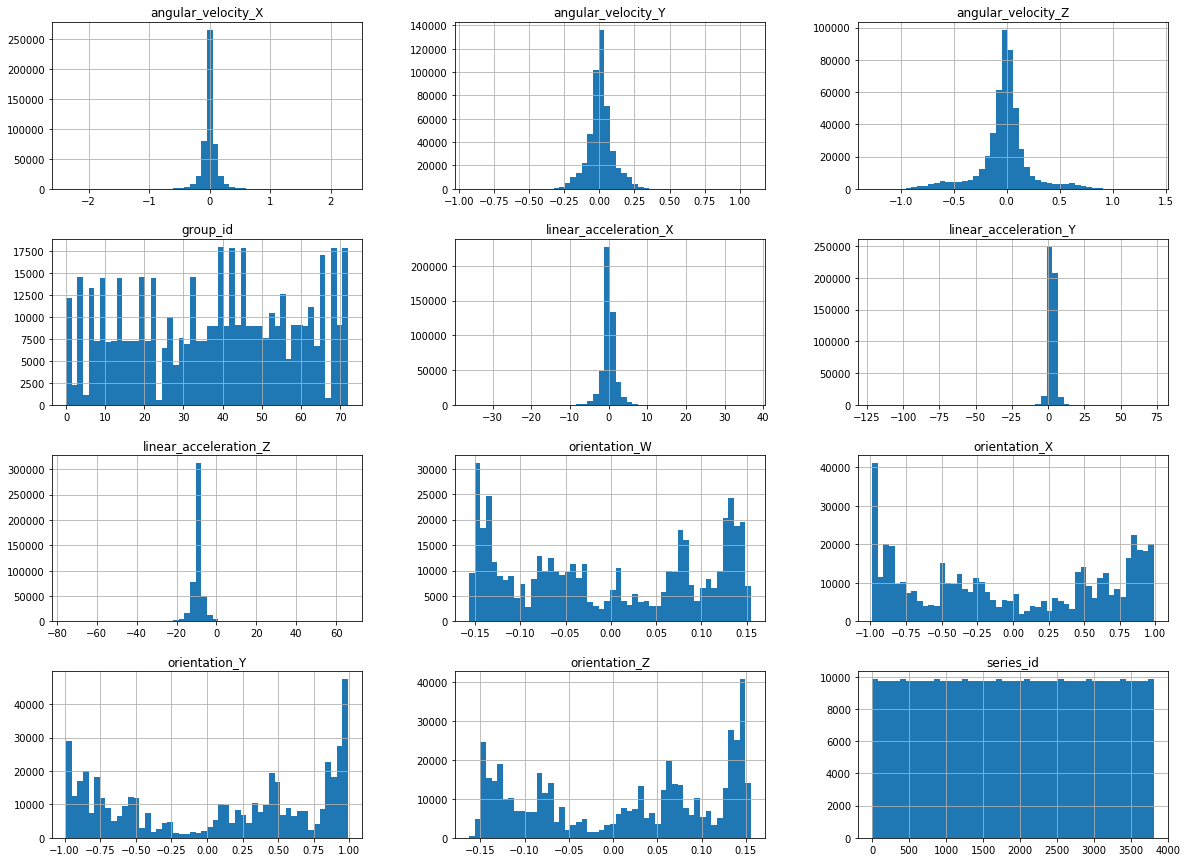

In [21]:
plt.figure();
train.hist(bins=50, figsize=(20, 15))

from sklearn import preprocessing
X_train_lin['X_scaled'] = preprocessing.scale(X_train_lin.orientation_X)
# scaler = preprocessing.StandardScaler().fit(X_train_lin)

# print(scaler)
# X_train_scale = scaler.transform(X_train_lin) 


X_train_scale= pd.DataFrame(X_train_scale)

plt.figure();
X_train_scale.hist(bins=50, figsize=(20, 15))

X_train_lin.orientation_X.hist()

X_train_lin.X_scaled.hist()

min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax= min_max_scaler.fit_transform(X_train_lin)
X_train_minmax = pd.DataFrame(X_train_minmax)

X_train_lin.drop('X_scaled', axis=1, inplace=True)

quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train_trans = quantile_transformer.fit_transform(X_train_lin)
X_train_trans = pd.DataFrame(X_train_trans)

In [22]:
train.dtypes

row_id                    object
series_id                  int64
orientation_X            float64
orientation_Y            float64
orientation_Z            float64
orientation_W            float64
angular_velocity_X       float64
angular_velocity_Y       float64
angular_velocity_Z       float64
linear_acceleration_X    float64
linear_acceleration_Y    float64
linear_acceleration_Z    float64
group_id                   int64
surface                   object
dtype: object

### Label encoding

In [23]:
list1 = train.group_id.unique()
list1

array([13, 31, 20, 22,  1, 34, 33, 11, 26, 25, 12,  7, 21,  8,  9, 28, 15,
       27, 35, 32, 23, 14, 30,  3, 29, 16,  0, 10, 19,  4, 18,  6, 17,  5,
        2, 24, 69, 70, 71, 60, 62, 59, 45, 56, 41, 53, 40, 68, 49, 46, 42,
       38, 61, 43, 51, 44, 55, 65, 37, 57, 54, 72, 64, 66, 36, 48, 47, 52,
       39, 58, 50, 63, 67], dtype=int64)

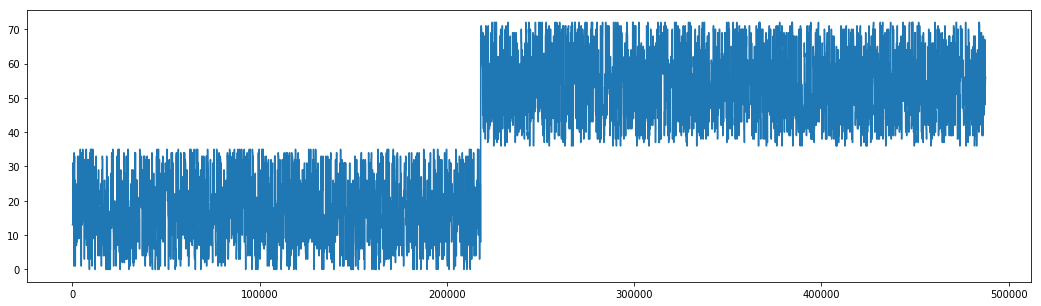

In [24]:
train.group_id.plot(figsize=(18,5))


In [25]:
le=LabelEncoder()
for col in test.columns.values:
	if test[col].dtypes=='object':
		data=train[col].append(test[col])
		le.fit(data.values)
		train[col]=le.transform(train[col])
		test[col]=le.transform(test[col])

train_lin = train.copy()

train_lin.shape

train_lin.columns

train_lin.dtypes

print(train_lin['surface'].unique())
train_lin['surface']= le.fit_transform(train_lin['surface'])
train_lin['surface'].unique()

train_lin.head()

from sklearn.linear_model import LinearRegression


y_lin=train_lin["group_id"]
X_lin=train_lin.drop('group_id', axis=1)
X_lin = X_lin.drop('surface', axis=1)
X_train_lin, X_validation_lin, y_train_lin, y_validation_lin = train_test_split(X_lin, y_lin, test_size=0.20)  

lm = LinearRegression()
lm.fit(X_train_lin,y_train_lin)

y_pred_lin=lm.predict(X_validation_lin)
# scores = []
# kfold = KFold(n_splits=3, shuffle=True, random_state=42)
# for i, (train_lin1, test_lin1) in enumerate(kfold.split(X_lin, y_lin)):
#  model1.fit(X_lin.iloc[train_lin1,:], y_lin.iloc[train_lin1,:])



# score = lm.score(y_validation_lin, y_pred_lin)
# scores.append(score)
# print(scores)
from sklearn.metrics import mean_squared_error, r2_score
print('Coefficients: \n', lm.coef_)
print("Mean squared error: %.2f"
      % mean_squared_error(y_validation_lin, y_pred_lin))
print('Variance score: %.2f' % r2_score(y_validation_lin, y_pred_lin))


X_validation_lin.shape

plt.scatter(y_validation_lin,y_pred_lin)

### Predict group_id for test data

lin_pred = lm.predict(test)


lin_pred = lin_pred.round()

test['surface'] = lin_pred

test.head()

## split data
### Divide in to train and validation


In [26]:
y=train["surface"]
X=train.drop('surface', axis=1)
X=X.drop('group_id', axis=1)


quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X[X.columns] = quantile_transformer.fit_transform(X[X.columns])


plt.figure();
X.hist(bins=50, figsize=(20, 15))

## test standardization
test[test.columns] = quantile_transformer.fit_transform(test[test.columns])

In [34]:
#from sklearn.model_selection import train_test_split  
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20)  
print("X_train", X_train.shape)
print("X_validation", X_validation.shape)
print("y_train", y_train.shape)
print("y_validation", y_validation.shape)
y.unique()

X_train (390144, 12)
X_validation (97536, 12)
y_train (390144,)
y_validation (97536,)


array(['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc',
       'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood'],
      dtype=object)

In [35]:
test.shape

(488448, 12)

### there are 9 levels in the target 

## Build a model

from sklearn.linear_model import LogisticRegression
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_validation)
print("Accuracy: %s%%" % (100*accuracy_score(y_validation, y_pred)))
print(confusion_matrix(y_validation, y_pred))
print(classification_report(y_validation, y_pred))

## Random Forest model

seed = 7
num_folds = 10

# Params for Random Forest
num_trees = 100
max_features = 3
models = []
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))

# evalutate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


In [36]:
random_forest = RandomForestClassifier(n_estimators=50,max_features=5)
random_forest.fit(X_train, y_train)
predictions_rf = random_forest.predict(X_validation)
print("Accuracy: %s%%" % (100*accuracy_score(y_validation, predictions_rf)))
print('----------------')
print(confusion_matrix(y_validation, predictions_rf))
print('----------------')
print(classification_report(y_validation, predictions_rf))

Accuracy: 99.86774114173228%
----------------
[[ 4974     0     0     0     0     0     1     7     0]
 [    0 19768     3     0     5     5     1     0    13]
 [    0     1  9363     0     1     0     0     4     0]
 [    0     0     0   548     0     0     0     0     0]
 [    0    11    11     0  7844     1     0     0    10]
 [    3     4     0     0     4 18684     2     7     1]
 [    2     0     0     0     0     2  7562     1     0]
 [    1     0     0     0     0     7     0 13134     0]
 [    2    15     1     0     3     0     0     0 15530]]
----------------
                        precision    recall  f1-score   support

                carpet       1.00      1.00      1.00      4982
              concrete       1.00      1.00      1.00     19795
         fine_concrete       1.00      1.00      1.00      9369
            hard_tiles       1.00      1.00      1.00       548
hard_tiles_large_space       1.00      1.00      1.00      7877
              soft_pvc       1.00     

random_forest1 = RandomForestClassifier(n_estimators=50,max_features=5)
random_forest1.fit(X_train, y_train)
predictions_rf = random_forest1.predict(X_validation)
print("Accuracy: %s%%" % (100*accuracy_score(y_validation, predictions_rf)))
print('----------------')
print(confusion_matrix(y_validation, predictions_rf))
print('----------------')
print(classification_report(y_validation, predictions_rf))

### Grid Search

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

cv_params = {'learning_rate': [0.001, 0.01, 0.1]}
ind_params = {'n_estimators': 100, 'seed':0,  'subsample': 0.9, 'colsample_bytree':1.0,
              'objective': 'multi:softprob', 'max_depth': 7, 'min_child_weight': 1}
optimized_xgb = GridSearchCV(XGBClassifier(**ind_params), 
                             cv_params, scoring = 'neg_log_loss', cv = 4, n_jobs = -1, verbose=3) 

optimized_xgb.fit(X_train, y_train)
print('Final Optimzed Scores')
optimized_xgb.grid_scores_


In [ ]:

model_xgb = XGBClassifier(n_estimators=100, seed= 0, learning_rate= 0.1, subsample= 0.9, 
                               colsample_bytree= 0.8, eval_metric= 'mlogloss', max_depth= 7, 
                               min_child_weight= 1, gamma= 0)

model_xgb.fit(X_train, y_train)

predictions_xgb_opt = model_xgb.predict(X_validation)

# evaluate predictions
accuracy = accuracy_score(y_validation, predictions_xgb_opt)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

## predictions on test data

In [38]:
# predication on  test data 

from scipy import stats

predictions = random_forest.predict(test)
print(len(predictions))
final_pred = pd.DataFrame()
final_pred['series_id']= X_test_robo['series_id']
final_pred['series_id']=final_pred['series_id'].astype('str')
final_pred['surface']= predictions
final_pred.head()

488448


,series_id,surface
0,0,tiled
1,0,tiled
2,0,tiled
3,0,tiled
4,0,tiled


In [39]:
arpana = final_pred.groupby(['series_id'], as_index=False, sort=False).agg(lambda x: stats.mode(x)[0][0])
arpana.head()

C:\Users\panch\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning:

The input array could not be properly checked for nan values. nan values will be ignored.



,series_id,surface
0,0,tiled
1,1,carpet
2,2,wood
3,3,soft_tiles
4,4,wood


In [40]:
arpana.to_csv('samplesubmission_rf_With_stdztn.csv', index=False)

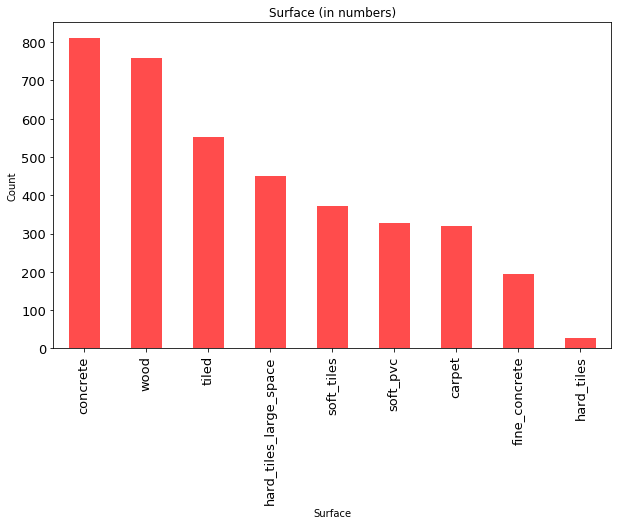

In [41]:
# plt.figure(figsize=(10,10)
arpana.surface.value_counts().plot(kind='bar',
                                 figsize=(10,6),
                                  color="red",
                                  alpha = 0.7,
                                  fontsize=13)
plt.title('Surface (in numbers)')
plt.xlabel('Surface')
plt.ylabel('Count')
plt.show()

### Important Features

In [ ]:
importances = random_forest.feature_importances_
plt.bar(range(len(random_forest.feature_importances_)), random_forest.feature_importances_)
plt.show()

indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%d. feature %d : %s : (%f)" % (f + 1, indices[f], X.iloc[:,indices[f]].name, importances[indices[f]]))

In [ ]:
import seaborn as sns
target = train["surface"]
train_without_target = train.drop(["surface"],axis=1)
corr = train_without_target.corr()
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr,cmap='coolwarm',vmax=.3)